# Brazilian E-Commerce Public Dataset by Olist

In [1]:
import numpy as np
import pandas as pd
from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
%matplotlib inline

import os

from datetime import datetime
from datetime import timedelta
import missingno as msno

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option("display.max_columns", None)

plt.rc('font', family='Noto Sans')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 불러오기
file_path = "../data/total_merged.csv"
df = pd.read_csv(file_path, index_col = 0)
df.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1,credit_card,1,18.12,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3,voucher,1,2.00,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2,voucher,1,18.59,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0


## TASK 1: 데이터 전처리

### 1-1. 결측치 비율 시각화 및 결측치 처리
- 결측치 비율 `10% 미만` : 제거 또는 대체
- 결측치 비율 `10% 이상 20% 미만` : 모델 기반 처리
- 결측치 비율 `20% 이상` : 모델 기반 처리

In [3]:
# 결측치 비율 구함
null_total = df.isnull().sum()
null_count = df.isnull().count()
null_pct = round((null_total/null_count)*100, 1)

# 결측치 개수, 퍼센트 데이터프레임으로 생성
missing = pd.concat([null_total, null_pct], axis=1, keys=["Total", "Percent"])
missing

,Total,Percent
order_id,0,0.0
customer_id,0,0.0
order_status,0,0.0
order_purchase_timestamp,0,0.0
order_approved_at,15,0.0
order_delivered_carrier_date,1245,1.1
order_delivered_customer_date,2567,2.2
order_estimated_delivery_date,0,0.0
customer_unique_id,0,0.0
customer_zip_code_prefix,0,0.0


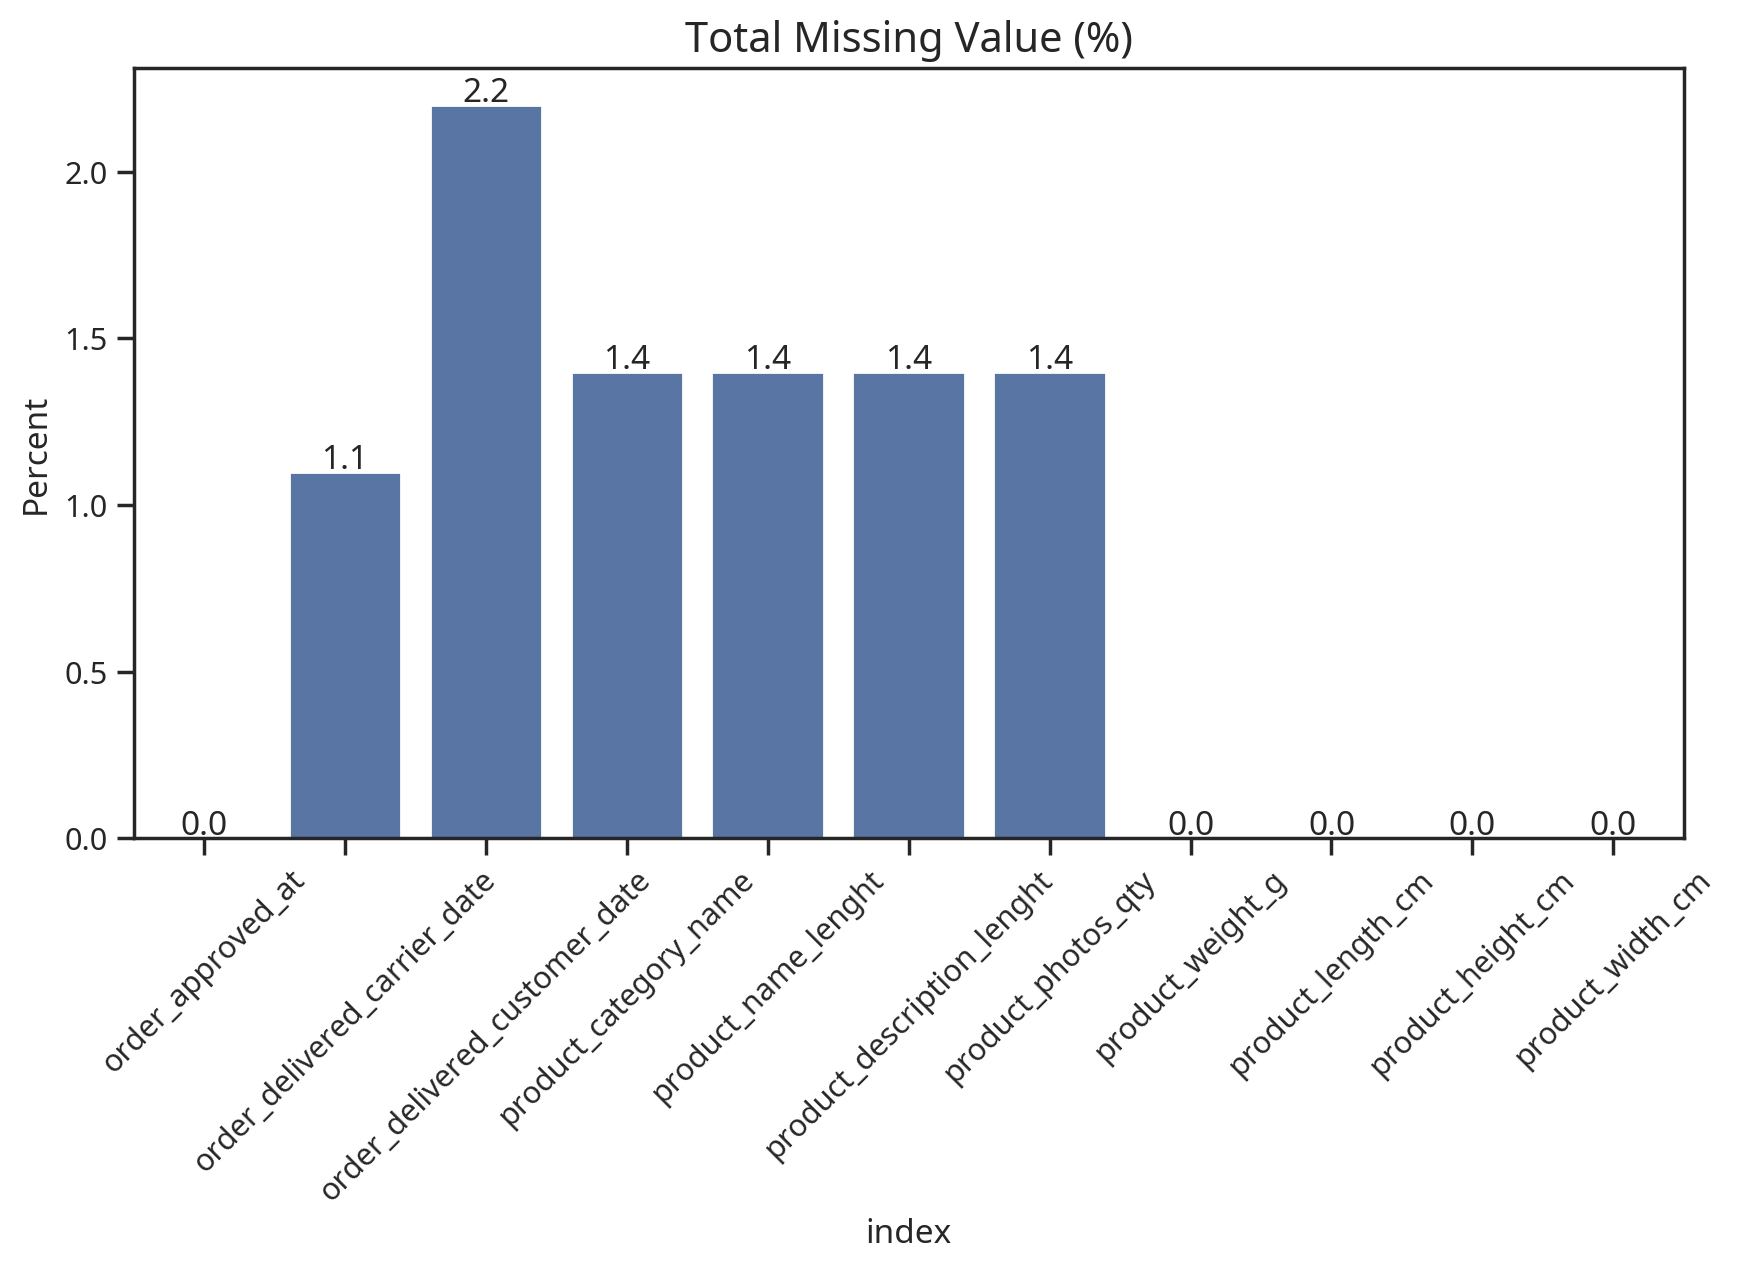

In [4]:
# 결측치 비율 시각화
plt.figure(figsize=(10, 5))
sns_pct = sns.barplot(x="index", y="Percent", data=missing[missing["Total"]!=0].reset_index())
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=45)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                   # .get_height() : y좌표

    plt.text(bar.get_x() + bar.get_width()/2,   # 퍼센트 글자 위치
             height+0.01,                        # 퍼센트 글자 높이
             "%.1f" % height,                   # 퍼센트 소수점 지정
             ha="center")                       # 가운데 정렬

# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Total Missing Value (%)", fontsize=15)
plt.show()

결측치가 존재하는 컬럼들의 결측치 비율이 매우 낮다 (약 1 ~ 2%) → 제거하기로 결정

In [5]:
# 결측치 처리 전과 처리 후 비교
print("결측치 drop 전 데이터프레임 row 수 :", df.shape[0])
print("결측치 drop 후 데이터프레임 row 수 :", df.dropna().shape[0])
print("결측치 drop 비율", round((df.shape[0]-df.dropna().shape[0])/df.shape[0], 2), "%")

# 결측치 제거
df_mod = df.dropna()

결측치 drop 전 데이터프레임 row 수 : 117601
결측치 drop 후 데이터프레임 row 수 : 113390
결측치 drop 비율 0.04 %


### 1-2. 주요 시각화

In [22]:
# 결제 날짜에서 연도만 빼온다
df_mod["purchased_year"] = pd.to_datetime(df_mod["order_purchase_timestamp"]).dt.year
df_mod["purchased_month"] = pd.to_datetime(df_mod["order_purchase_timestamp"]).dt.month

df_mod.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,purchased_year,purchased_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1,credit_card,1,18.12,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,2017,10
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3,voucher,1,2.00,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,2017,10
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2,voucher,1,18.59,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,2017,10


In [19]:
city_counts = df_mod.groupby(["customer_city"]).count()
city_top10 = city_counts.sort_values(by="order_id", ascending=False).head(10)
city_top10

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,purchased_year
customer_city,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sao paulo,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868,17868
rio de janeiro,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822,7822
belo horizonte,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134,3134
brasilia,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374
curitiba,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768,1768
campinas,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686,1686
porto alegre,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589,1589
salvador,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435,1435
guarulhos,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348


In [20]:
payment_counts = df_mod.groupby("payment_type").count()
payment_counts = payment_counts.sort_values(by="order_id", ascending=False)
payment_counts

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,purchased_year
payment_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
credit_card,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706,83706
boleto,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047,22047
voucher,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012,6012
debit_card,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625,1625


In [21]:
category_counts = df_mod.groupby("product_category_name").count()
category_counts = category_counts.sort_values(by="order_id", ascending=False).head(5)
category_counts

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,purchased_year
product_category_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cama_mesa_banho,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649,11649
beleza_saude,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761,9761
esporte_lazer,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731,8731
moveis_decoracao,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553,8553
informatica_acessorios,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897,7897


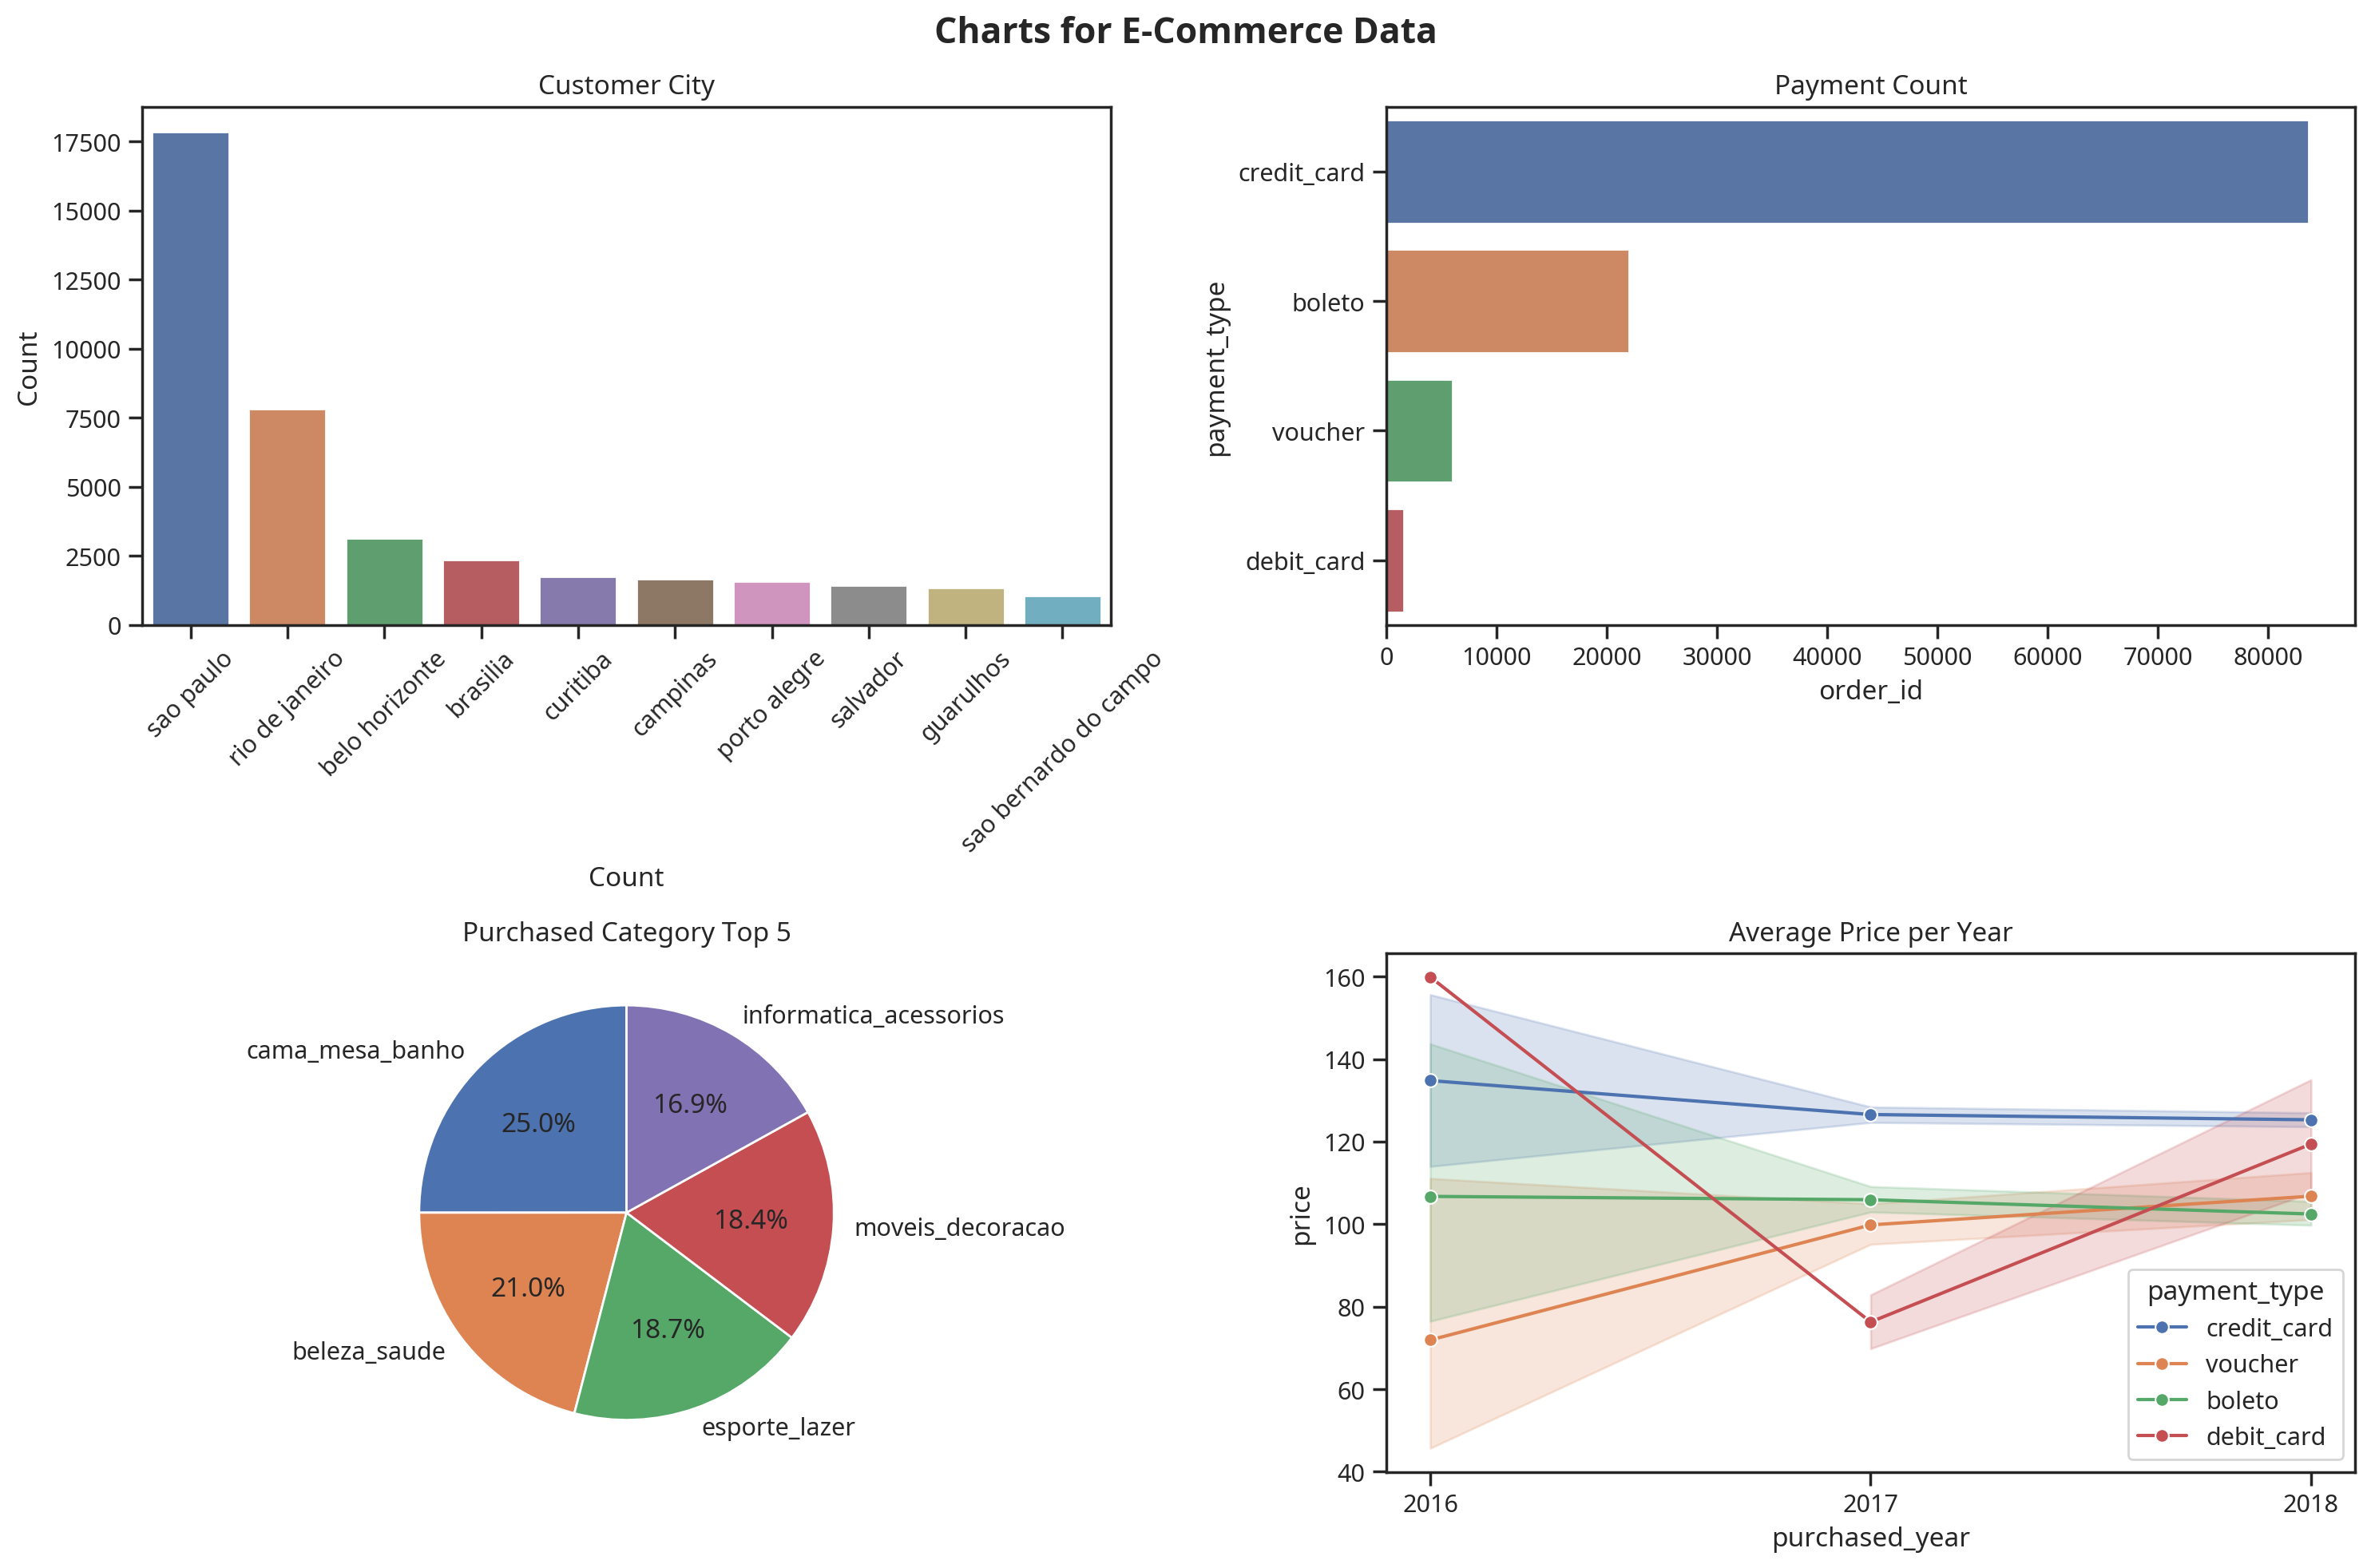

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Charts for E-Commerce Data', fontsize=16, fontweight='bold')

# 첫 번째 plot
sns.barplot(data=city_top10, x="customer_city", y="customer_id", ax=axes[0, 0], hue="customer_city")
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Customer City')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)

# 두 번째 plot
sns.barplot(data=payment_counts, x="order_id", y="payment_type", ax=axes[0, 1], hue="payment_type")
axes[0, 0].set_xlabel('Count')
axes[0, 1].set_title('Payment Count')

# 세 번째 plot
wedges, texts, autotexts = axes[1, 0].pie(category_counts['order_id'], 
               labels=category_counts.index, 
               autopct="%1.1f%%", 
               startangle=90)
axes[1, 0].set_title('Purchased Category Top 5')

# 네 번째 plot
sns.lineplot(data=df_mod, x="purchased_year", y="price", hue="payment_type", marker='o', ax=axes[1, 1])
axes[1, 1].set_xticks([2016, 2017, 2018])
axes[1, 1].set_xticklabels(['2016', '2017', '2018'])
axes[1, 1].set_title('Average Price per Year')

fig.tight_layout()
plt.show()

### 1-3. 상관 관계 확인

In [24]:
num_cols = df_mod.select_dtypes(include="number").columns.tolist()
df_mod_corr = round(df_mod[num_cols].corr(), 2)

df_mod_corr.style.background_gradient()

,customer_zip_code_prefix,order_item_id,price,freight_value,payment_sequential,payment_installments,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,purchased_year,purchased_month
customer_zip_code_prefix,1.000000,0.000000,0.040000,0.230000,-0.030000,0.060000,0.050000,0.020000,0.020000,0.020000,0.000000,0.000000,0.010000,-0.010000,-0.030000,-0.000000
order_item_id,0.000000,1.000000,-0.060000,-0.030000,-0.000000,0.070000,0.270000,-0.020000,-0.010000,-0.050000,-0.000000,0.010000,0.030000,-0.010000,0.000000,-0.000000
price,0.040000,-0.060000,1.000000,0.410000,0.000000,0.280000,0.740000,0.020000,0.200000,0.050000,0.340000,0.140000,0.220000,0.170000,-0.000000,0.000000
freight_value,0.230000,-0.030000,0.410000,1.000000,0.010000,0.190000,0.370000,0.030000,0.090000,0.020000,0.610000,0.300000,0.390000,0.320000,0.040000,0.010000
payment_sequential,-0.030000,-0.000000,0.000000,0.010000,1.000000,-0.090000,-0.070000,-0.000000,-0.010000,-0.010000,0.030000,0.030000,0.020000,0.030000,-0.040000,0.010000
payment_installments,0.060000,0.070000,0.280000,0.190000,-0.090000,1.000000,0.270000,0.020000,0.040000,-0.000000,0.180000,0.120000,0.120000,0.140000,-0.050000,0.030000
payment_value,0.050000,0.270000,0.740000,0.370000,-0.070000,0.270000,1.000000,0.000000,0.160000,0.010000,0.310000,0.140000,0.220000,0.150000,0.010000,0.010000
product_name_lenght,0.020000,-0.020000,0.020000,0.030000,-0.000000,0.020000,0.000000,1.000000,0.090000,0.150000,0.020000,0.060000,-0.030000,0.060000,0.020000,0.010000
product_description_lenght,0.020000,-0.010000,0.200000,0.090000,-0.010000,0.040000,0.160000,0.090000,1.000000,0.120000,0.060000,0.000000,0.070000,-0.070000,0.040000,-0.010000
product_photos_qty,0.020000,-0.050000,0.050000,0.020000,-0.010000,-0.000000,0.010000,0.150000,0.120000,1.000000,0.020000,0.050000,-0.030000,0.010000,-0.010000,0.010000


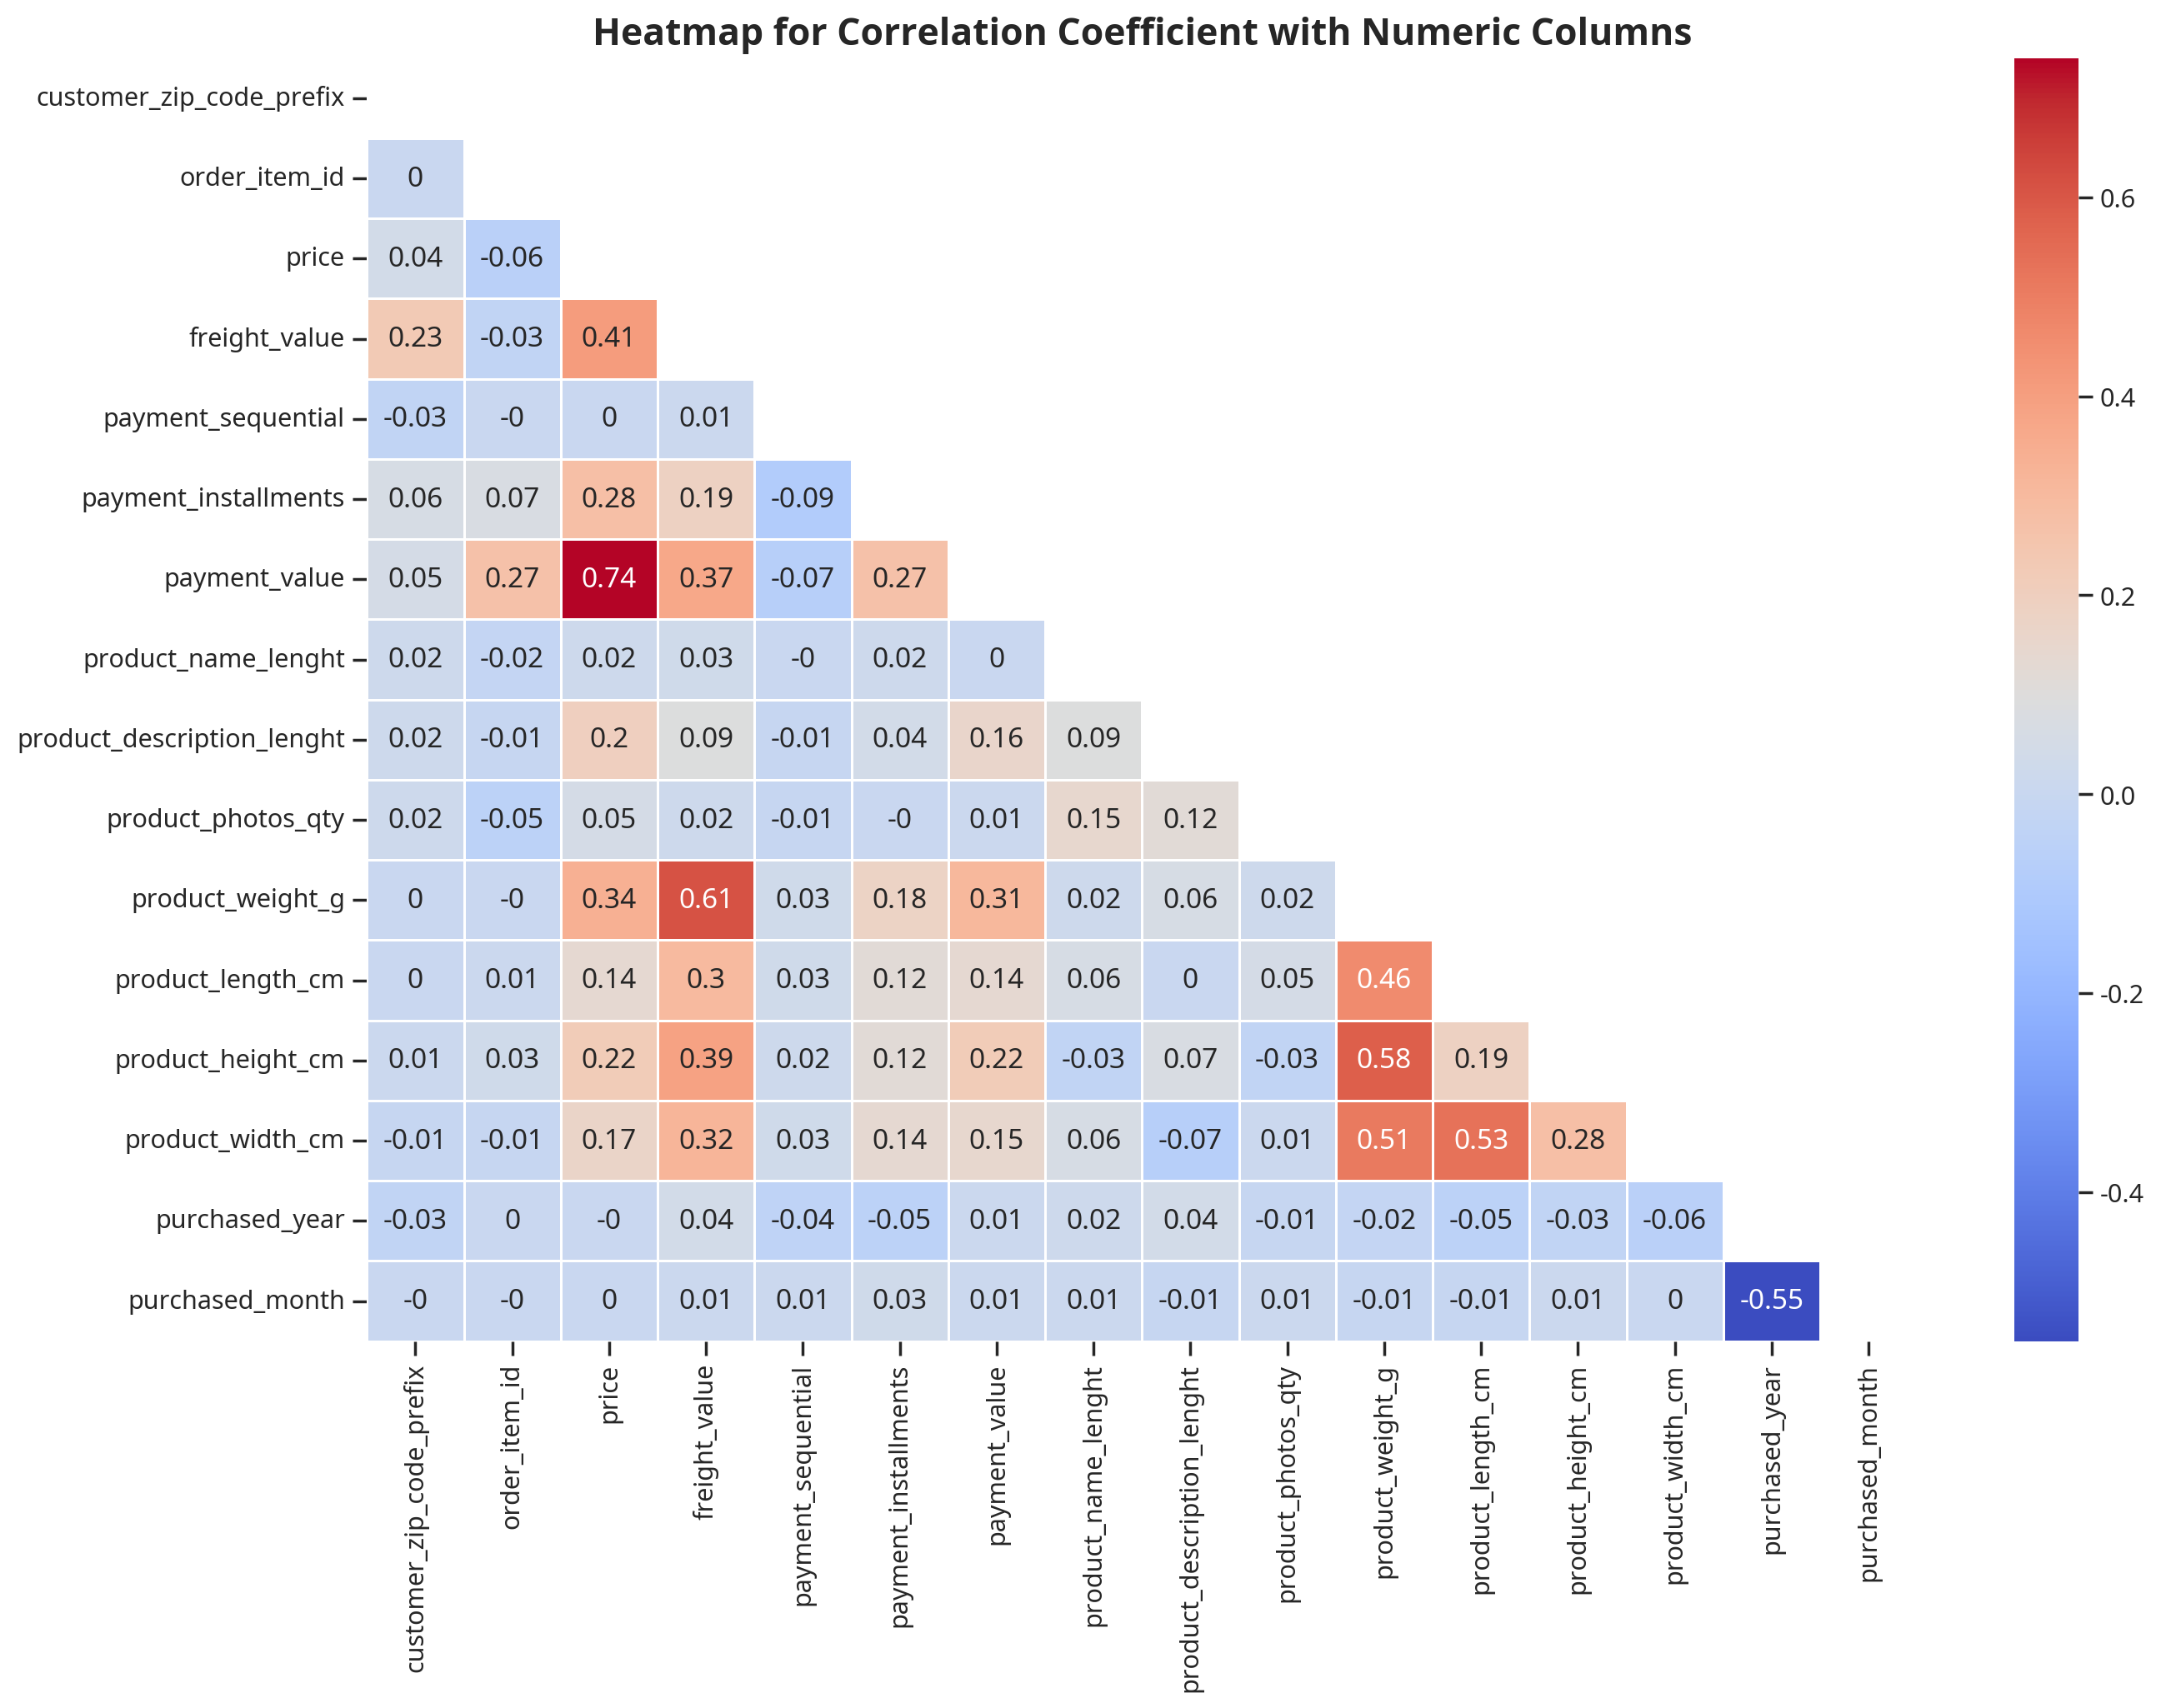

In [25]:
plt.figure(figsize=(15,10))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df_mod_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_mod_corr,
            annot=True,         # 실제 값을 표시한다
            mask=mask,          # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,      # 경계면 실선으로 구분하기
            cmap='coolwarm')

plt.title("Heatmap for Correlation Coefficient with Numeric Columns", fontsize=16, fontweight='bold')
plt.show()

## TASK 2: 컬럼 분석 노트
- `customer_city`: 구매 고객의 소재지는 상 파울루가 가장 많았고, 그 다음이 리우 데 자네이루이다.
    - 대도시 위주로 구매가 많이 발생했다 → 나머지 도시들도 대도시이지만, 상파울루 및 리우에 대다수 분포
- `payment_type`: credit card로 결제한 고객이 압도적으로 많고, 약 25%가 boleto를 사용한다 (브라질 특유의 결제 수단)
- `category_counts`
    - 다양한 분야의 카테고리들이 판매되었다 (종합 쇼핑몰)
        - cama_mesa_banho (bed_bath_table)
        - beleza_saude (health_beauty)
        - esporte_lazer(sports_leisure)
        - moveis_decoracao (furniture_deco)
        - informatica_acessorios (computers_accessories)

## Week 3) TASK 1. 이상치 처리

In [24]:
df_mod.head(3)
# 수치형 변수 목록 확인
numeric_cols = df_mod.select_dtypes(include="number").columns

# 수치형 변수 목록에서, customer_zip_code_prefix, order_item_id는 제거한다 (수치형 변수가 아니다)
remove_numerics_cols =  {'customer_zip_code_prefix', 'order_item_id'}
numeric_cols = [i for i in numeric_cols if i not in remove_numerics_cols]
numeric_cols

['price',
 'freight_value',
 'payment_sequential',
 'payment_installments',
 'payment_value',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm']

In [48]:
# product_category_name별로 price 합계를 계산
price_sum_by_category = df_mod.groupby('product_category_name')['price'].sum()

# price 합계 기준 내림차순 정렬 후 상위 5개 범주 선택 및 합산
top_price_sum = price_sum_by_category.sort_values(ascending=False).head(5).sum()

# 전체 데이터의 price 합계 계산
total_price = df_mod['price'].sum()

# 비율 계산 (percentage)
ratio = (top_price_sum / total_price) * 100

print(f"상위 5개 범주의 price 합계가 전체 price 합계에서 차지하는 비율: {ratio:.2f}%")


상위 5개 범주의 price 합계가 전체 price 합계에서 차지하는 비율: 40.15%


In [49]:
# product_category_name별로 price 합계를 계산
price_sum_by_category = df_mod.groupby('product_category_name')['price'].sum()

# price 합계 기준 내림차순 정렬 후 상위 5개 범주 선택 및 합산
top_price_sum = price_sum_by_category.sort_values(ascending=False).head(20).sum()

# 전체 데이터의 price 합계 계산
total_price = df_mod['price'].sum()

# 비율 계산 (percentage)
ratio = (top_price_sum / total_price) * 100

print(f"상위 20개 범주의 price 합계가 전체 price 합계에서 차지하는 비율: {ratio:.2f}%")


상위 20개 범주의 price 합계가 전체 price 합계에서 차지하는 비율: 85.11%


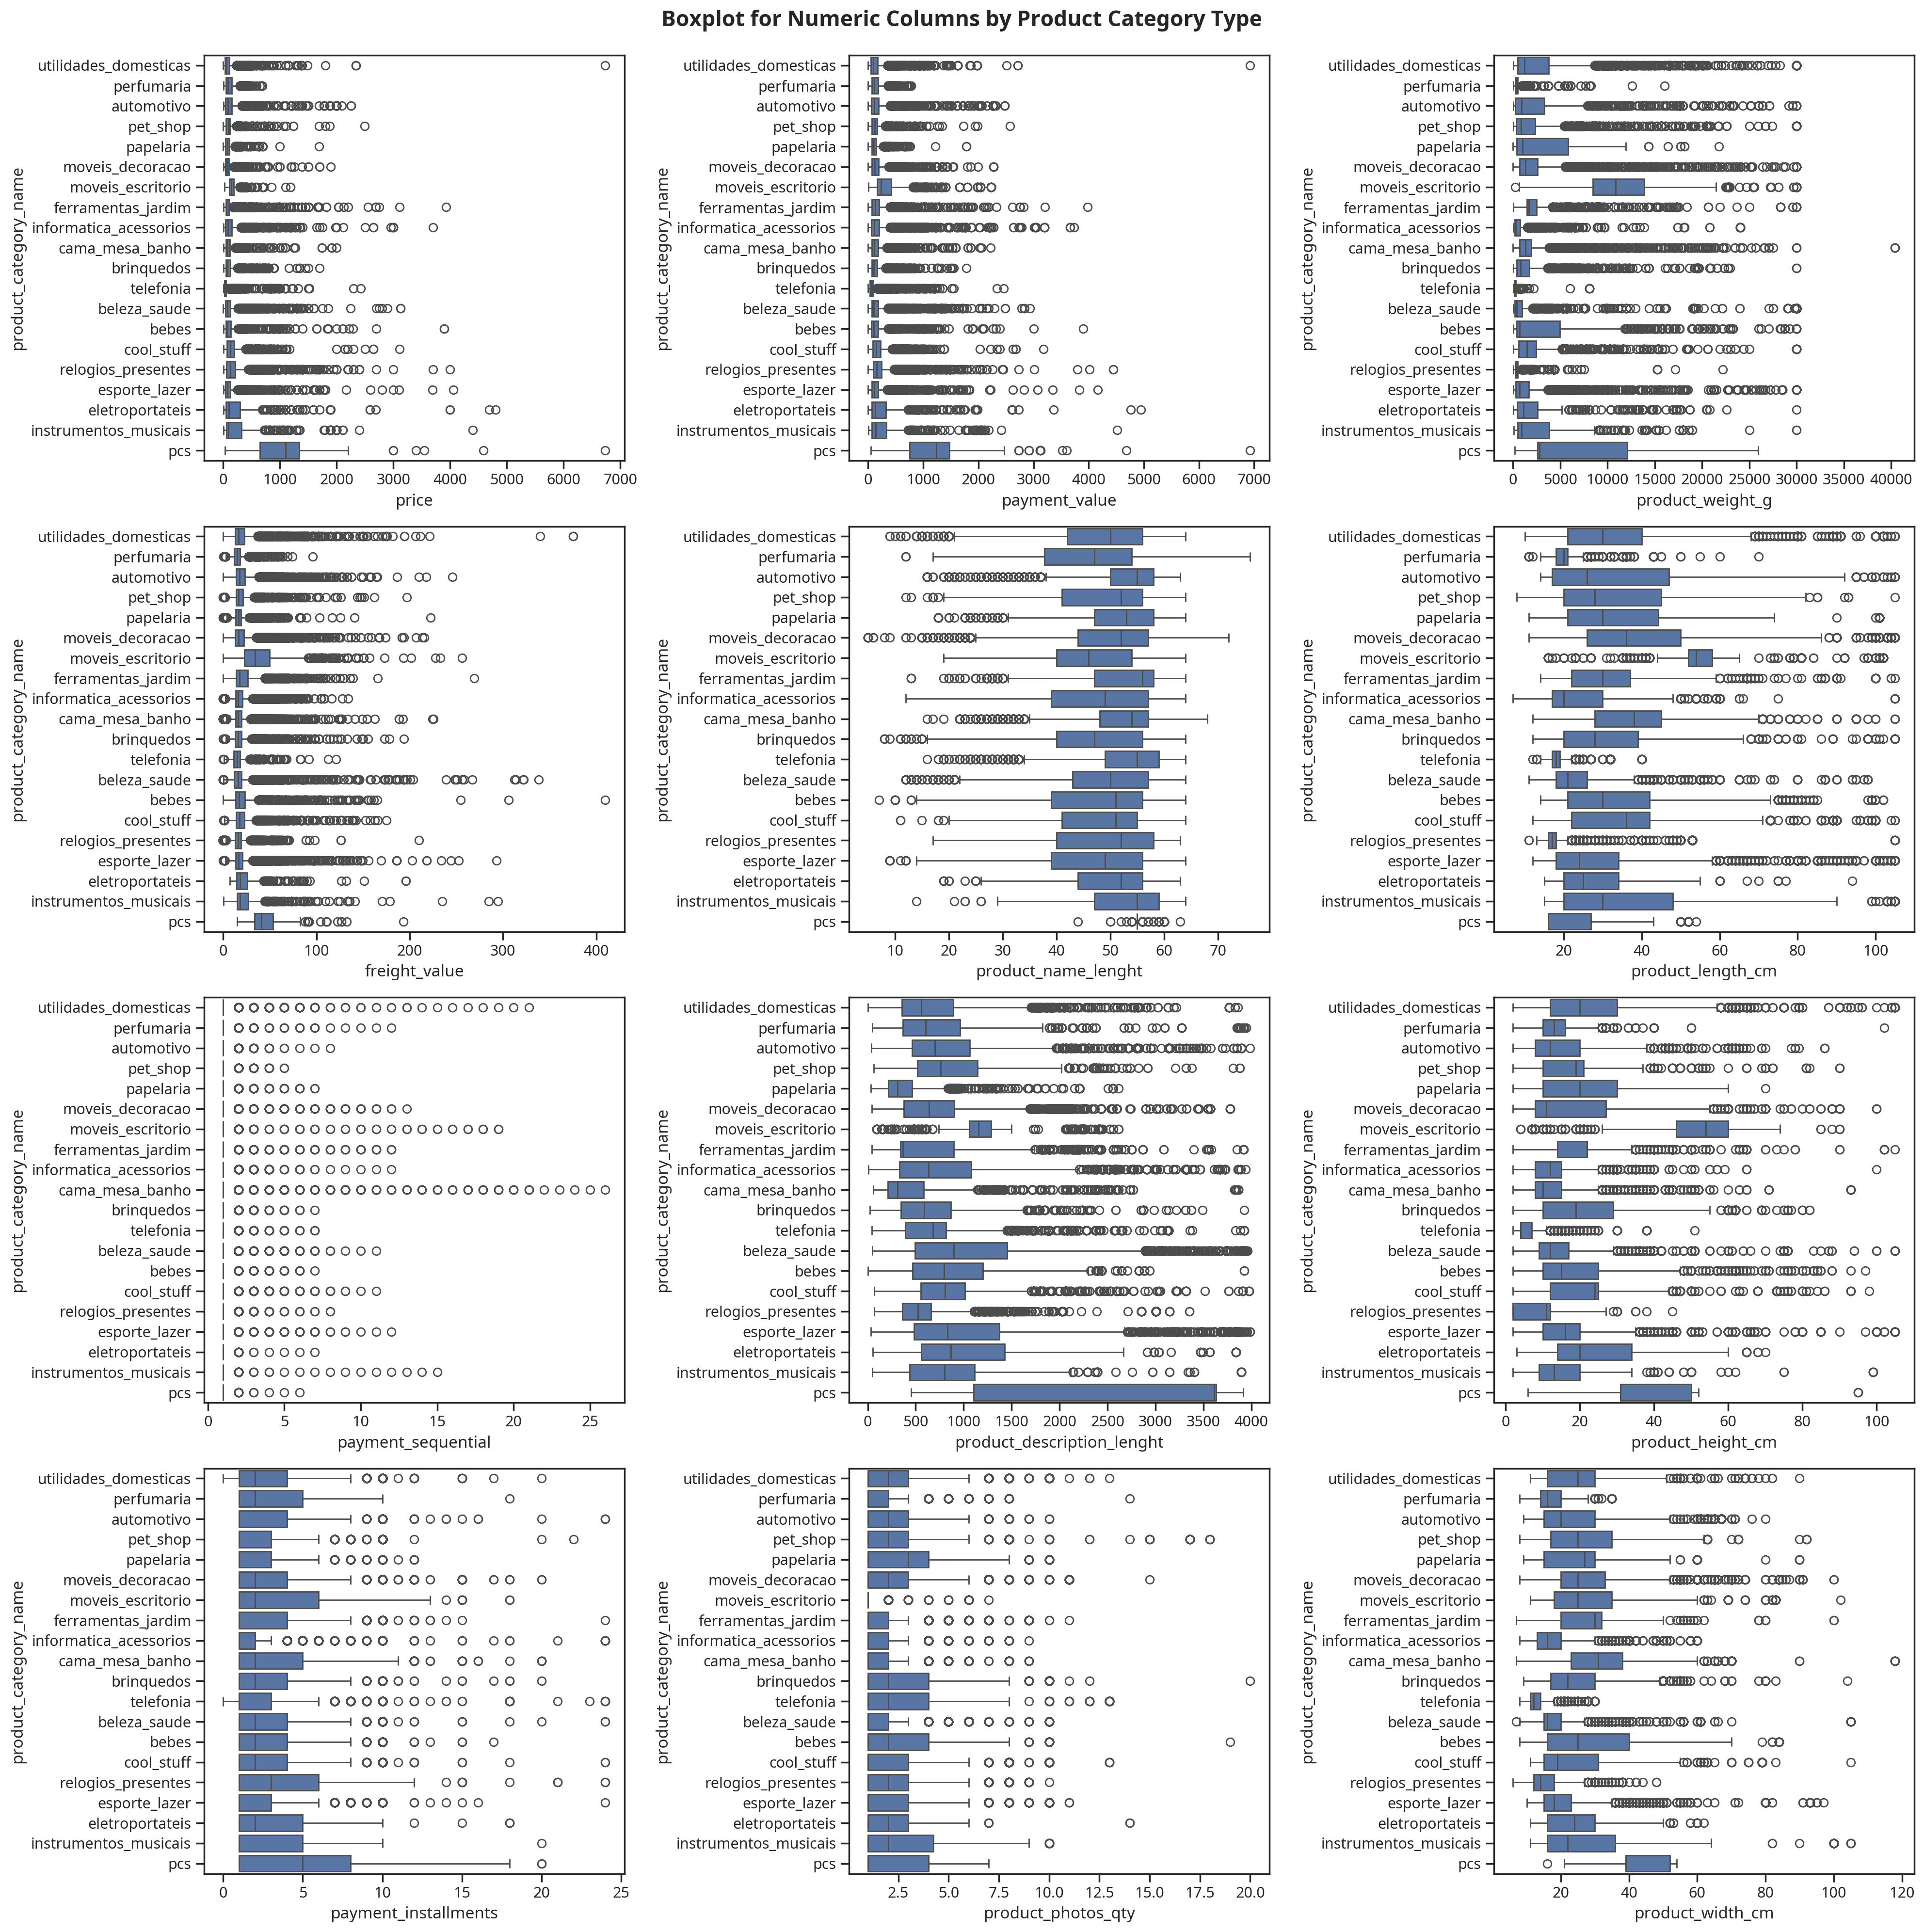

In [51]:
# product_category_name별로 price 합계를 계산한 후, 상위 20개 범주 선택
top_categories = df_mod.groupby('product_category_name')['price'].sum().sort_values(ascending=False).head(20).index
df_top = df_mod[df_mod['product_category_name'].isin(top_categories)]

# subplot 생성
nrows, ncols = 4, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))

# axes를 1차원 array로 펴기 (transpose 후 flatten)
axes = axes.T.flatten()

# 각 numeric column에 대해 boxplot 그리기
for col, ax in zip(numeric_cols, axes):
    sns.boxplot(data=df_top, x=col, y="product_category_name", ax=ax)
    # 필요 시 추가 플롯 설정 가능 (예: sns.stripplot)

plt.suptitle("Boxplot for Numeric Columns by Product Category Type", fontsize=16, fontweight='bold', y=0.995)
fig.tight_layout()
plt.show()


- e-commerce 쇼핑몰의 상품 카테고리가 다양하기 때문에, 수치형 변수 값의 범위는 다양할 것
    - `boxplot`을 그렸을 때 이상치처럼 보이긴 하지만, 일단 전부 있을 법한 데이터라고 생각하고 별도의 이상치 처리 skip

In [33]:
# 하나의 transaction_id에서 여러 활동 이루어진 것 확인
df_mod["order_id"].value_counts()

order_id
895ab968e7bb0d5659d16cd74cd1650c    63
fedcd9f7ccdc8cba3a18defedd1a5547    38
ccf804e764ed5650cd8759557269dc13    26
68986e4324f6a21481df4e6e89abcf01    24
a3725dfe487d359b5be08cac48b64ec5    24
                                    ..
878a17cea3ed0bda2fb9726c2d4ad57c     1
af099467911b979b79b3a49231876086     1
3a2012438f0919dc24e43b9e8b21c4f1     1
3f2502be2cb245c8c7ca170ddf39465b     1
66dea50a8b16d9b4dee7af250b4be1a5     1
Name: count, Length: 95128, dtype: int64

In [34]:
df_mod[df_mod["order_id"]=="895ab968e7bb0d5659d16cd74cd1650c"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
84420,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,17,voucher,1,16.70,cama_mesa_banho,37.0,86.0,2.0,1300.0,50.0,9.0,41.0
84421,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,1,voucher,1,2.61,cama_mesa_banho,37.0,86.0,2.0,1300.0,50.0,9.0,41.0
84422,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,13,voucher,1,16.70,cama_mesa_banho,37.0,86.0,2.0,1300.0,50.0,9.0,41.0
84423,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,16,voucher,1,16.70,cama_mesa_banho,37.0,86.0,2.0,1300.0,50.0,9.0,41.0
84424,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,19,voucher,1,0.24,cama_mesa_banho,37.0,86.0,2.0,1300.0,50.0,9.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84478,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,3.0,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,2017-08-14 20:43:31,83.80,5.12,15,voucher,1,16.70,utilidades_domesticas,56.0,548.0,8.0,450.0,30.0,20.0,11.0
84479,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,3.0,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,2017-08-14 20:43:31,83.80,5.12,20,voucher,1,4.61,utilidades_domesticas,56.0,548.0,8.0,450.0,30.0,20.0,11.0
84480,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,3.0,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,2017-08-14 20:43:31,83.80,5.12,14,voucher,1,16.70,utilidades_domesticas,56.0,548.0,8.0,450.0,30.0,20.0,11.0
84481,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,

## Week 3) Task 2. Feature Engineering

- 날짜 파생 컬럼 생성
    - `order_purchase_timestamp` 컬럼을 년, 월, 일, 시간으로 나눈다

In [56]:
# pd.to_datetime으로 order_purchase_timestamp 컬럼을 datetime type으로 변경
df_mod['order_purchase_timestamp'] = pd.to_datetime(df_mod['order_purchase_timestamp'])

# 연, 월, 일, 시간 추출
df_mod['order_purchase_year'] = df_mod['order_purchase_timestamp'].dt.year
df_mod['order_purchase_month'] = df_mod['order_purchase_timestamp'].dt.month
df_mod['order_purchase_day'] = df_mod['order_purchase_timestamp'].dt.day
df_mod['order_purchase_hour'] = df_mod['order_purchase_timestamp'].dt.hour

# 요일  (영어로 요일 표기, ex: Monday, Tuesday, ...)
df_mod['order_purchase_dayofweek'] = df_mod['order_purchase_timestamp'].dt.day_name()


In [ ]:
# order_purchase_month에 대해 season 컬럼 생성 (3개월 단위: 봄, 여름, 가을, 겨울)
def month_to_season(m):
    if m in [3, 4, 5]:
        return 'Spring'  # 봄
    elif m in [6, 7, 8]:
        return 'Summer'  # 여름
    elif m in [9, 10, 11]:
        return 'Fall'    # 가을
    else:
        return 'Winter'  # 겨울

df_mod['season'] = df_mod['order_purchase_month'].apply(month_to_season)

# order_purchase_day에 대해 day_type 컬럼 생성
# 요일 정보(order_purchase_dayofweek)를 사용하여 주말(Saturday, Sunday)은 Weekend, 나머지는 Weekday로 분류
df_mod['day_type'] = df_mod['order_purchase_dayofweek'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# order_purchase_hour에 대해 hour_type 컬럼 생성
# 7시부터 18시는 "Day", 그 외는 "Night"으로 분류
def hour_to_type(h):
    return 'Day' if 7 <= h <= 18 else 'Night'

df_mod['hour_type'] = df_mod['order_purchase_hour'].apply(hour_to_type)

# order_purchase_dayofweek에 대해서도 dayofweek_type 컬럼 생성 (주말/주중)
df_mod['dayofweek_type'] = df_mod['order_purchase_dayofweek'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')


In [ ]:
# 파생 컬럼 확인
df_mod[['order_purchase_year', 'order_purchase_month', 'order_purchase_day', 'order_purchase_hour', 'order_purchase_dayofweek', 'season', 'day_type', 'hour_type', 'dayofweek_type']].head(3)

,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_hour,order_purchase_dayofweek,season,day_type,hour_type,dayofweek_type
0,2017,10,2,10,Monday,Fall,Weekday,Day,Weekday
1,2017,10,2,10,Monday,Fall,Weekday,Day,Weekday
2,2017,10,2,10,Monday,Fall,Weekday,Day,Weekday


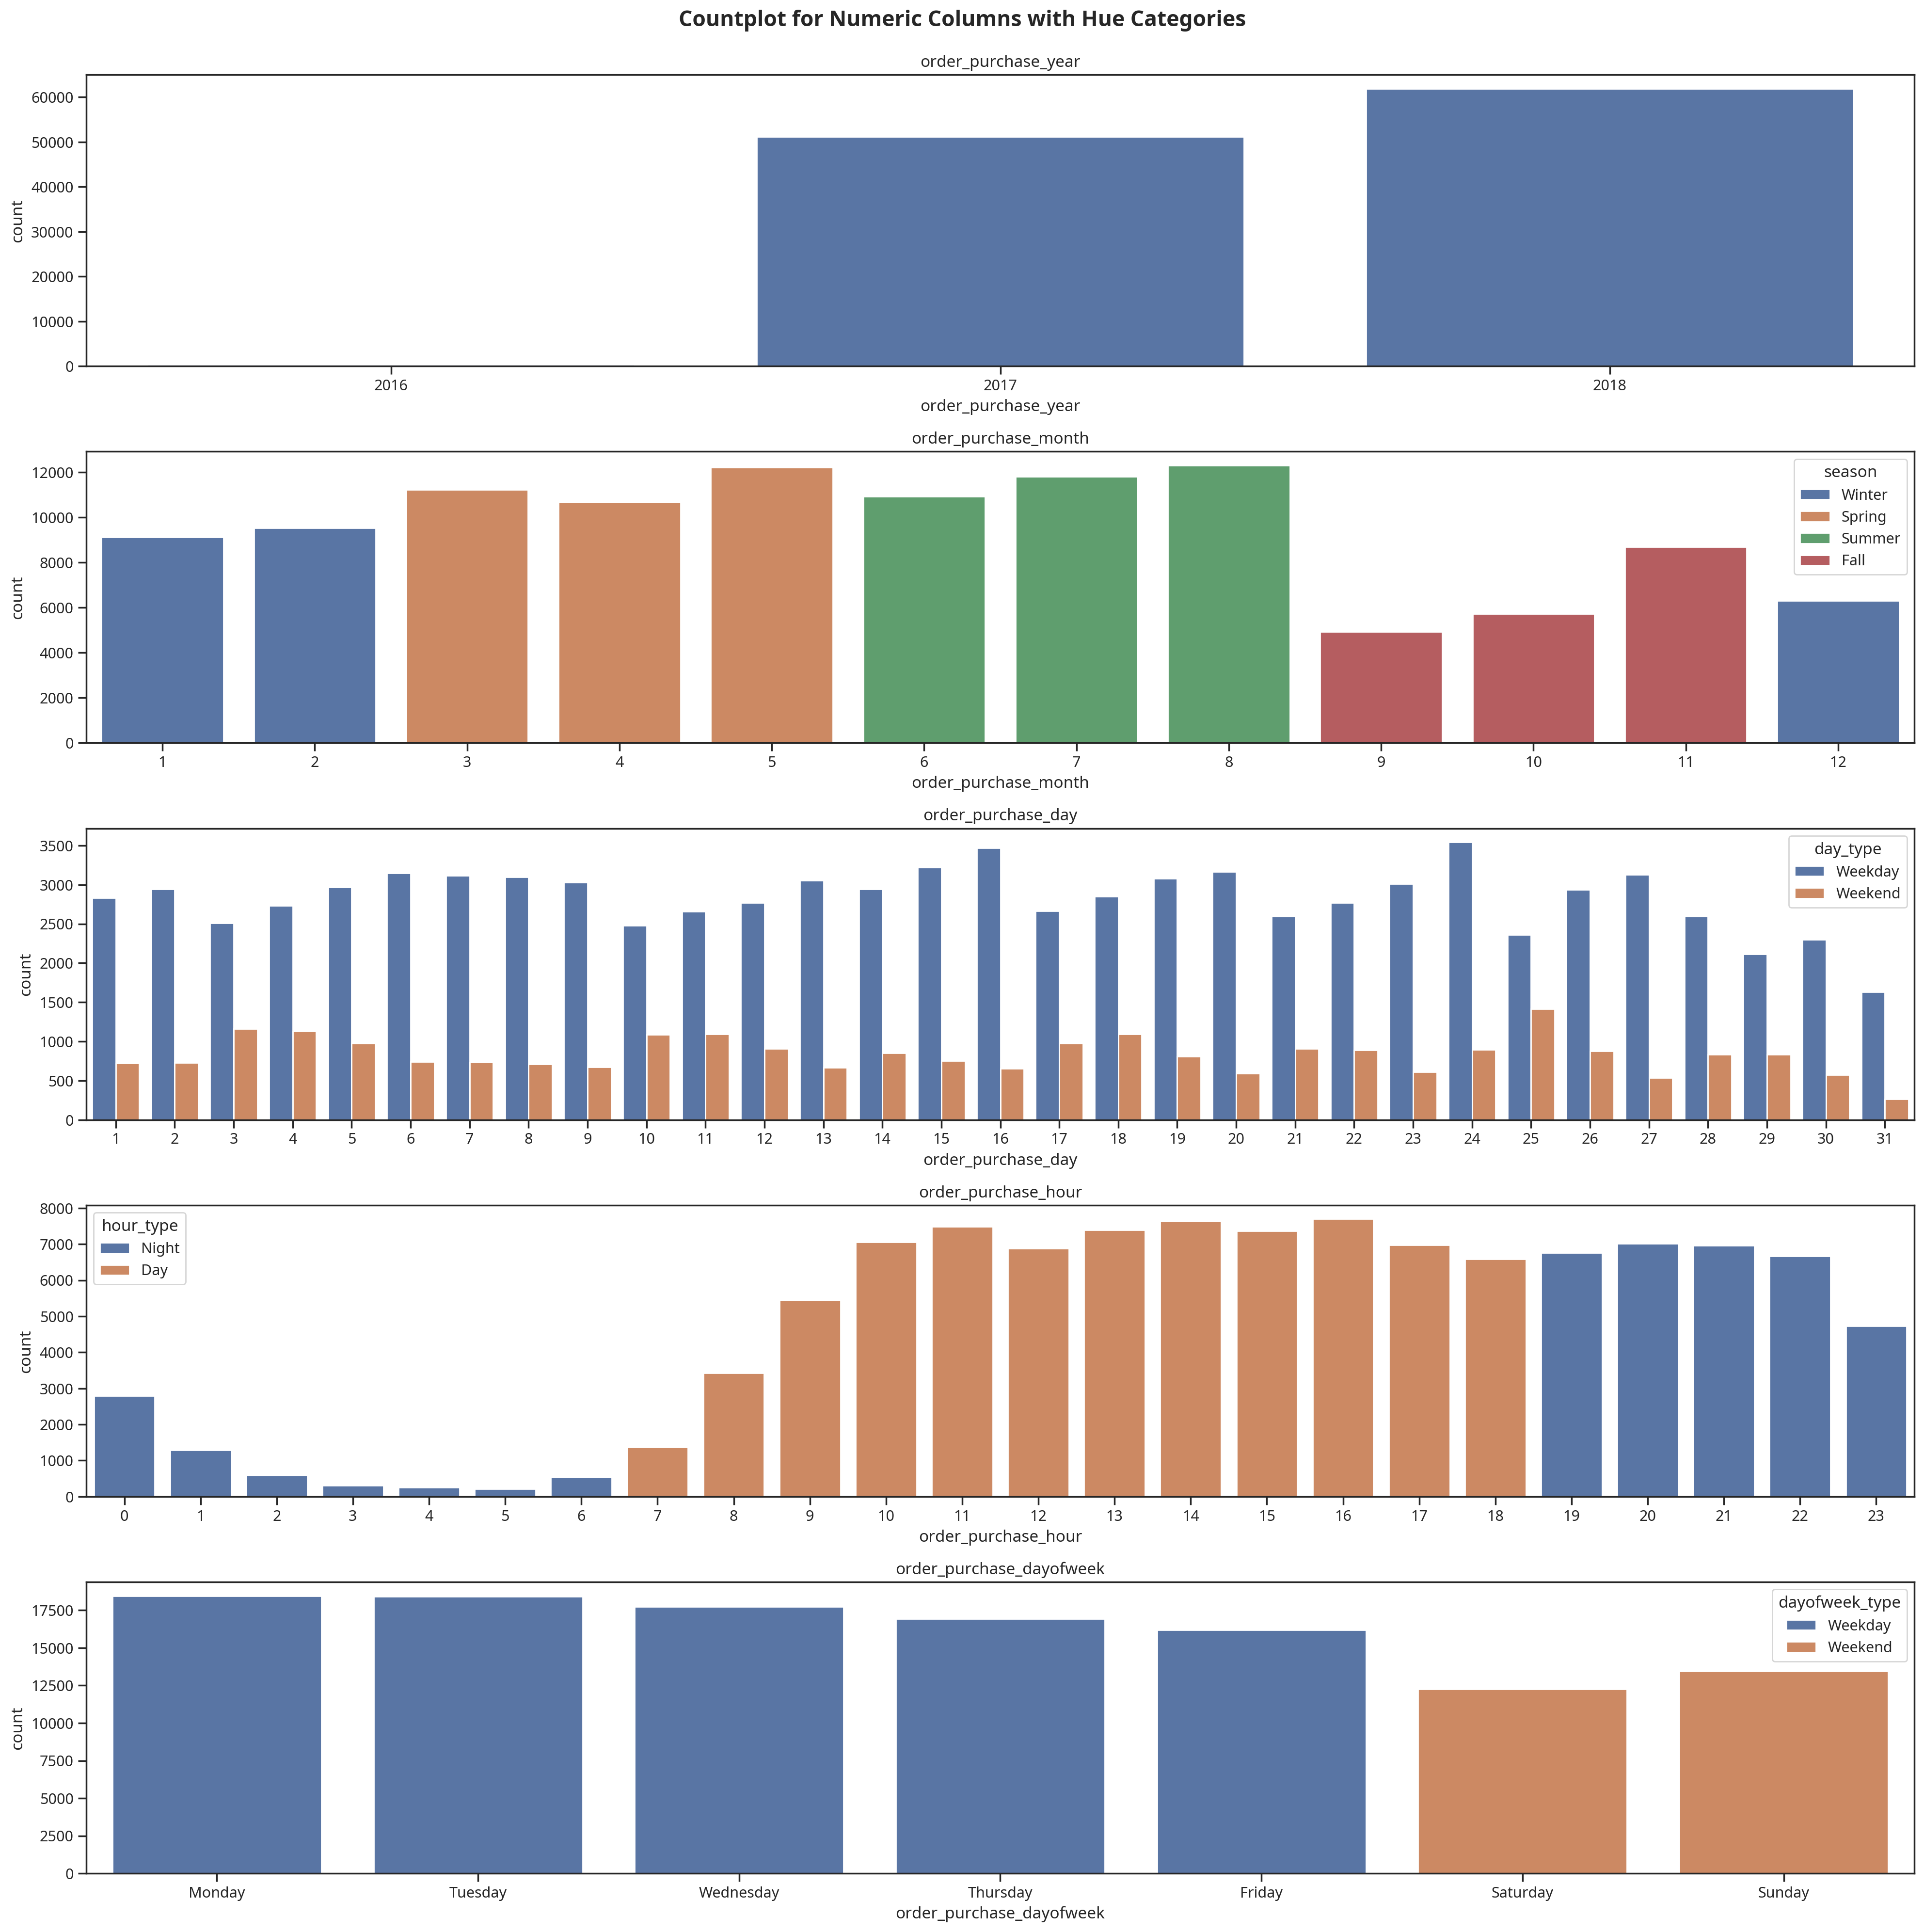

In [ ]:
# order_purchase_dayofweek의 x축 순서를 월요일부터 일요일로 지정
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 각 subplot에 사용할 hue 지정 매핑
hue_mapping = {
    'order_purchase_year': None,           # hue 없음
    'order_purchase_month': 'season',        # season 컬럼 사용
    'order_purchase_day': 'day_type',        # day_type 컬럼 사용
    'order_purchase_hour': 'hour_type',      # hour_type 컬럼 사용
    'order_purchase_dayofweek': 'dayofweek_type'  # dayofweek_type 컬럼 사용
}

# Subplot 생성 (5행 1열)
nrows, ncols = 5, 1
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))
axes = axes.T.flatten()  # transpose 후 flatten하여 1차원 배열로 만듦

# 6. 각 컬럼에 대해 countplot 그리기
for col, ax in zip(['order_purchase_year', 'order_purchase_month', 'order_purchase_day', 'order_purchase_hour', 'order_purchase_dayofweek'], axes):
    hue = hue_mapping.get(col)
    # order_purchase_dayofweek의 경우 x축 순서를 days_order로 지정
    if col == 'order_purchase_dayofweek':
        sns.countplot(data=df_mod, x=col, ax=ax, hue=hue, order=days_order)
    else:
        if hue:
            sns.countplot(data=df_mod, x=col, ax=ax, hue=hue)
        else:
            sns.countplot(data=df_mod, x=col, ax=ax)
    ax.set_title(col)  # 각 subplot에 제목 추가

plt.suptitle("Countplot for Numeric Columns with Hue Categories", fontsize=16, fontweight='bold', y=0.995)
fig.tight_layout()
plt.show()